In [76]:
import pandas as pd
import re, os, pickle
import gensim
import gensim.corpora as corpora
from tqdm import tqdm
import spacy

In [38]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_short_text(data_path):
    data = pd.read_csv(data_path, encoding='utf-8')
    data = data.dropna(subset=['text'])
    data = data.rename(columns={'text': 'message', 'id':'message_id'})
    data = data.reset_index()
    
    threshold = 3
    data['message_split'] = [i.split(' ') for i in data['message']]
    lengths = [len(i) for i in data['message_split']]
    
    drop_ids = [i for i in range(len(lengths)) if lengths[i] < threshold]
    data = data.drop(drop_ids)
    data = data.drop(['message_split', 'index'], axis=1)
    data = data.reset_index().drop(['index'], axis=1) 

    return data

In [24]:
def process_and_tokenize(data_text):
    data_text = [re.sub('\S*@\S*\s?', '', sent) for sent in data_text] # remove emails
    data_text = [re.sub('\+?\d[\d .-]{8,}\d', '', sent) for sent in data_text] #remove phone numbers
    data_text = [re.sub('\s+', ' ', sent) for sent in data_text] # remove newlines
    data_text = [re.sub("\'", "", sent) for sent in data_text] # remove single quotes

    tokenized_data_text = [gensim.utils.simple_preprocess(str(sent), deacc=True) for sent in data_text]

    return tokenized_data_text

In [39]:
def ngram_and_lemmatize(tokenized_data_text, make_bigram=True, make_trigram=False, 
                        allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):

    bigram = gensim.models.Phrases(tokenized_data_text, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[tokenized_data_text], threshold=100) 

    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    data_text = [[word for word in text if word not in stop_words] for text in tokenized_data_text]
    
    if make_bigram:
        data_text = [bigram_mod[sent] for sent in tqdm(data_text, desc="Making Bigrams ...")]

    if make_bigram and make_trigram:
        data_text = [trigram_mod[bigram_mod[sent]] for sent in tqdm(data_text, desc="Making Trigrams ...")]

    lemm_data_text = []
    
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in tqdm(data_text, desc="Lemmatizing ..."):
        doc = nlp(" ".join(sent)) 
        lemm_data_text.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    return lemm_data_text

In [86]:
data_path = "../combined_comments_3.csv"
csv_name = data_path.split("/")[-1]
save_dir = csv_name.split(".")[0]
save_path = f"./{save_dir}"

df = remove_short_text(data_path)
tokenized_data_text = process_and_tokenize(df.message)

In [81]:
lemmatized_data_text = ngram_and_lemmatize(tokenized_data_text)

Lemmatizing ...: 100%|██████████| 68076/68076 [02:59<00:00, 378.66it/s]


In [82]:
ids_to_drop = [i for i in range(len(lemmatized_data_text)) if len(lemmatized_data_text[i]) == 0]
lemmatized_data_text_dropped = [i for i in lemmatized_data_text if len(i) != 0]

df_dropped = df.drop(ids_to_drop).reset_index()
df_dropped = df_dropped.drop(['index'], axis=1)

In [83]:

id2word = corpora.Dictionary(lemmatized_data_text_dropped)
corpus = [id2word.doc2bow(text) for text in lemmatized_data_text_dropped]


In [84]:
if not os.path.exists(save_path):
    os.mkdir(save_path)

df_dropped.to_csv(f"{save_path}/df_dropped.csv", index=False)

with open(f"{save_path}/lemmatized_data_text_dropped.pickle", "wb") as f:
    pickle.dump(lemmatized_data_text_dropped, f)

with open(f"{save_path}/id2word.pickle", "wb") as f:
    pickle.dump(id2word, f)

with open(f"{save_path}/corpus.pickle", "wb") as f:
    pickle.dump(corpus, f)

In [57]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('fentanyl', 1), ('idea', 1), ('many', 1), ('use', 1)],
 [('child', 1), ('spiritual', 1), ('warefare', 1)],
 [('havevto', 1), ('never', 1), ('pain', 1), ('pray', 1), ('understand', 1)],
 [('much', 1), ('thank', 1)],
 [('day', 1), ('miss', 1), ('momma', 1), ('spending', 1), ('visit', 1)]]

In [7]:
from gensim.models import CoherenceModel
import gensim
from tqdm import tqdm
import pickle, os

In [11]:
def compute_coherence_values(id2word, corpus, texts, limit, start=5, step=10):
    home = os.getenv("HOME")
    os.environ.update({'MALLET_HOME':r'/home/users/iasamori/tiktok/mallet-2.0.8/'})
    mallet_path = f"{home}/tiktok/mallet-2.0.8/bin/mallet"
    
    coherence_values = []
    nums = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=43)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        nums.append(num_topics)
        
    return nums, coherence_values

In [12]:
save_path = "./combined_comments_3"

with open(f"{save_path}/lemmatized_data_text_dropped.pickle", "rb") as f:
    lemmatized_data_text_dropped = pickle.load(f)

with open(f"{save_path}/id2word.pickle", "rb") as f:
    id2word = pickle.load(f)

with open(f"{save_path}/corpus.pickle", "rb") as f:
    corpus = pickle.load(f)

In [13]:
nums, coherence_values = compute_coherence_values(id2word, corpus, lemmatized_data_text_dropped, limit=13)

100%|██████████| 1/1 [00:47<00:00, 47.46s/it]


In [15]:
nums, coherence_values

([5], [0.29243067500645054])

In [19]:
bigram = gensim.models.Phrases(data_text_tokenized, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_text_tokenized], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_text_tokenized[5]]])

[['many',
  'of',
  'them',
  'have',
  'no',
  'idea',
  'they',
  'are',
  'using',
  'fentanyl'],
 ['your', 'children', 'are', 'spiritual', 'warefare'],
 ['pray', 'they', 'never', 'havevto', 'understand', 'our', 'pain'],
 ['how', 'ya', 'doing'],
 ['thank', 'you', 'so', 'much'],
 ['happy',
  'birthday',
  'jackson',
  'hope',
  'you',
  're',
  'spending',
  'it',
  'visiting',
  'your',
  'momma',
  'that',
  'misses',
  'you',
  'more',
  'and',
  'more',
  'every',
  'day'],
 ['this', 'absolutely', 'agree'],
 ['so', 'sorry', 'and', 'on', 'his', 'bday'],
 ['so', 'so', 'sorry'],
 ['sorry', 'for', 'your', 'loss'],
 ['wish',
  'could',
  'ask',
  'you',
  'to',
  'reassure',
  'me',
  'it',
  'gets',
  'easier',
  'but',
  'youre',
  'years',
  'ahead',
  'of',
  'me',
  'it',
  'still',
  'hurts',
  'good',
  'luck',
  'in',
  'your',
  'new',
  'place',
  'need',
  'to',
  'let',
  'go'],
 ['of',
  'the',
  'farm',
  'raised',
  'my',
  'kids',
  'on',
  'with',
  'my',
  'husband',

In [3]:
data = pd.read_csv("../combined_comments_3.csv", encoding='utf-8')
data = data.dropna(subset=['text'])
data = data.rename(columns={'text': 'message', 'id':'message_id'})
data = data.reset_index()

threshold = 3
data['message_split'] = [i.split(' ') for i in data['message']]
lengths = [len(i) for i in data['message_split']]

drop_ids = [i for i in range(len(lengths)) if lengths[i] < threshold]
data = data.drop(drop_ids)
data = data.drop(['message_split', 'index'], axis=1)
data = data.reset_index().drop(['index'], axis=1)
data

,create_time,message_id,like_count,parent_comment_id,reply_count,message,video_id
0,1.698725e+09,7.295967e+18,0.0,7.260153e+18,0.0,many of them have no idea they are using fenta...,7.260153e+18
1,1.698725e+09,7.295968e+18,0.0,7.260153e+18,0.0,your children are spiritual warefare!,7.260153e+18
2,1.698725e+09,7.295967e+18,0.0,7.260153e+18,0.0,i pray they never havevto understand our pain,7.260153e+18
3,1.699370e+09,7.298738e+18,0.0,7.298692e+18,0.0,how ya doing,7.298692e+18
4,1.673488e+09,7.187574e+18,0.0,7.187541e+18,0.0,Thank you so much,7.187435e+18
...,...,...,...,...,...,...,...
69062,1.690226e+09,7.259465e+18,1.0,7.255254e+18,0.0,of course massive corporations are exploiting ...,7.255007e+18
69063,1.690226e+09,7.259465e+18,1.0,7.255254e+18,0.0,there is no justification for it. someone who ...,7.255007e+18
69064,1.690227e+09,7.259469e+18,1.0,7.255254e+18,0.0,I’m honestly not one to hate on anyone. I can ...,7.255007e+18
69065,1.690226e+09,7.259465e+18,1.0,7.255254e+18,0.0,in what world do you actually think it’s cool ...,7.255007e+18


# Dendograms

In [2]:
import dotenv
dotenv.load_dotenv()

True

In [123]:
from openai import AzureOpenAI
import os, pickle
import numpy as np
import random

In [3]:
def generate_embeddings(text, size="SMALL"): # model = "deployment_name"
    client = AzureOpenAI(
      api_key = os.getenv("AZURE_OPENAI_KEY"),  
      api_version = "2024-02-01",
      azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    )
    
    return client.embeddings.create(input = [text], model=os.getenv(f"DEPLOYMENT_NAME_{size}")).data[0].embedding

In [9]:
def download_emb(text, embedding_folder=f"{os.getenv('OAK')}/samori/tiktok/embeddings"):
    small_emb = generate_embeddings(text, size="SMALL")
    large_emb = generate_embeddings(text, size="LARGE")
    
    with open(f"{embedding_folder}/gensim_vocab_embedding_small.pkl", "rb") as f:
        emb_dict_small = pickle.load(f)
        emb_dict_small[text] = small_emb

    with open(f"{embedding_folder}/gensim_vocab_embedding_large.pkl", "rb") as f:
        emb_dict_large = pickle.load(f)
        emb_dict_large[text] = large_emb

    with open(f"{embedding_folder}/gensim_vocab_embedding_small.pkl","wb") as f:
        pickle.dump(emb_dict_small, f)

    with open(f"{embedding_folder}/gensim_vocab_embedding_large.pkl","wb") as f:
        pickle.dump(emb_dict_large, f)

    return (emb_dict_small, emb_dict_large)

In [23]:
def get_filtered_topics(model, threshold=0.80):
    
    # optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=65, id2word=id2word, random_seed=43)
    topics = model.show_topics(num_topics=66, num_words=16861, formatted=False)
    filtered_topics = {}
    for i in range(len(topics)):
        topic_list = topics[i][1]
        word_dict = {i[0]: i[1] for i in topic_list}
        
        words = list(word_dict.keys())
        values = list(word_dict.values())
    
        cumsum = np.cumsum(values)
        n = np.argmin(cumsum <= threshold)
    
        
        filtered_dict = dict(zip(words[:n], values[:n]))
        filtered_topics[i] = filtered_dict
        
    return filtered_topics

In [28]:
def get_topic_emb_dict(filtered_topics):

    oak = os.getenv('OAK')
    embedding_folder = f"{oak}/samori/tiktok/embeddings"
    
    with open(f"{embedding_folder}/gensim_vocab_embedding_small.pkl", "rb") as f:
        emb_dict_small = pickle.load(f)
    
    with open(f"{embedding_folder}/gensim_vocab_embedding_large.pkl", "rb") as f:
        emb_dict_large = pickle.load(f)
    
    topic_emb_small_dict = {}
    topic_emb_large_dict = {}
    for i in range(len(list(filtered_topics.keys()))):
        topic_dict_i = filtered_topics[i]
    
        terms = list(topic_dict_i.keys())
        terms = [i.replace("_"," ") for i in terms]
        # print(terms)
        # break
        values = list(topic_dict_i.values())
        values = np.array(values) / np.sum(values)
    
        topic_emb_small = np.zeros(1536)
        topic_emb_large = np.zeros(3072)
        
        for term_id in range(len(terms)):
            try:
                topic_emb_small += values[term_id] * np.array(emb_dict_small[terms[term_id]])
                topic_emb_large += values[term_id] * np.array(emb_dict_large[terms[term_id]])
            except KeyError:
                print(terms[term_id])
                emb_dict_small, emb_dict_large = download_emb(terms[term_id])
                topic_emb_small += values[term_id] * np.array(emb_dict_small[terms[term_id]])
                topic_emb_large += values[term_id] * np.array(emb_dict_large[terms[term_id]])
    
        topic_emb_small_dict[f"{i+1}"] = topic_emb_small
        topic_emb_large_dict[f"{i+1}"] = topic_emb_large
    return topic_emb_small_dict, topic_emb_large_dict

In [77]:
def get_tsne(topic_emb_dict):
    tsne_model = TSNE(n_components=2, random_state=42)
    reduced_emb = tsne_model.fit_transform(np.array(list(topic_emb_dict.values())))
    return reduced_emb

In [91]:
def get_optimal_distance(linkage_matrix, reduced_emb,  data_name='combined_comments_3', plot=True):
    test_ds = np.linspace(0.3,1,80)
    scores = []
    for test_d in test_ds:
        clusters = fcluster(linkage_matrix, test_d, criterion='distance')
        # print(clusters)
        score = silhouette_score(reduced_emb, clusters)
        scores.append(score)
        
    max_index = scores.index(max(scores[:40]))
    if plot:
        plt.plot(test_ds, scores)
        plt.scatter(test_ds[max_index], scores[max_index], color='red', marker='*')
        plt.ylabel('Silhouette Score')
        plt.xlabel('Cut off Distance')
        plt.grid()
        plt.savefig(f"./{data_name}/silhoutte_score_experiment.png")
        
    return round(test_ds[max_index], 2)

In [92]:
def plot_dendogram(linkage_matrix, distance, labels, data_name='combined_comments_3'):
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, 
               color_threshold=distance,
               labels = labels
              )
    plt.xlabel('Topic'); plt.ylabel('Distance')
    plt.savefig(f"./{data_name}/dendogram.png")
    plt.show()

In [167]:
def get_color_list(n, color_seed=42):
    unwanted_colors = ['white', 'whitesmoke', 'floralwhite','ghostwhite', 'mintcream', 'azure', 'lavenderblush', 'seashell', 'linen', 'ivory','aliceblue']
    all_colors = list(mcolors.CSS4_COLORS.keys())
    all_colors = [i for i in all_colors if i not in unwanted_colors]

    random.seed(color_seed)
    selected_colors = random.sample(all_colors, n)
    return selected_colors

In [168]:
def plot_tsne(clusters, reduced_emb, plot_labels, color=True, data_name='combined_comments_3', color_seed=42):
    color_list = get_color_list(max(clusters),color_seed)
    colors = [color_list[i-1] for i in clusters]
    
    plt.figure(figsize=(10, 8), dpi=120)
    if color:
        scatter = plt.scatter(reduced_emb[:,0], reduced_emb[:,1], c=colors)
    else:
        scatter = plt.scatter(reduced_emb[:,0], reduced_emb[:,1])
    
    for i in range(len(labels)):
        plt.text(reduced_emb[:,0][i]+0.05, reduced_emb[:,1][i], plot_labels[i], fontsize=8)
    
    plt.xlabel("TSNE 1")
    plt.ylabel("TSNE 2")
    plt.savefig(f"./{data_name}/tsne.png")
    plt.show()

In [124]:
import gensim
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

In [20]:
home = os.getenv("HOME")
os.environ.update({'MALLET_HOME':r'/home/users/iasamori/tiktok/mallet-2.0.8/'})
mallet_path = f"{home}/tiktok/mallet-2.0.8/bin/mallet"

data_name = "combined_comments_3"

with open(f"./{data_name}/id2word.pickle", "rb") as f:
    id2word = pickle.load(f)
    
with open(f"./{data_name}/corpus.pickle", "rb") as f:
    corpus = pickle.load(f)

In [22]:
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=65, id2word=id2word, random_seed=43)

In [25]:
filtered_topics = get_filtered_topics(optimal_model)

In [34]:
topic_emb_small_dict, topic_emb_large_dict = get_topic_emb_dict(filtered_topics)

In [82]:
reduced_emb = get_tsne(topic_emb_large_dict)

In [96]:
plot_labels = list(topic_emb_large_dict.keys())

In [69]:
df = pd.DataFrame(np.array(list(topic_emb_large_dict.values())))
dist_matrix = pdist(df)
linkage_matrix = linkage(dist_matrix, method='ward')

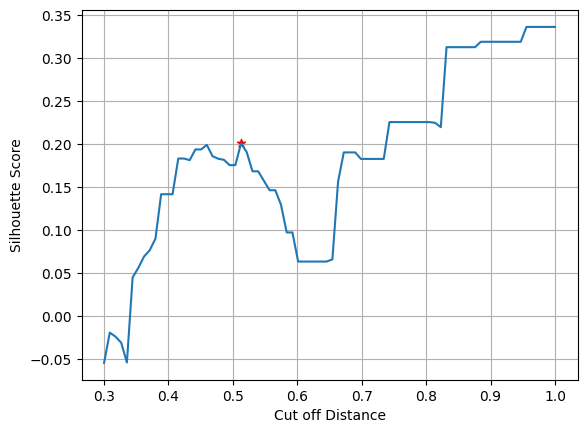

In [155]:
optimal_distance = get_optimal_distance(linkage_matrix, reduced_emb, data_name='combined_comments_3', plot=True)
# optimal_distance = get_optimal_distance(linkage_matrix, np.array(list(topic_emb_large_dict.values())), data_name='combined_comments_3', plot=True)

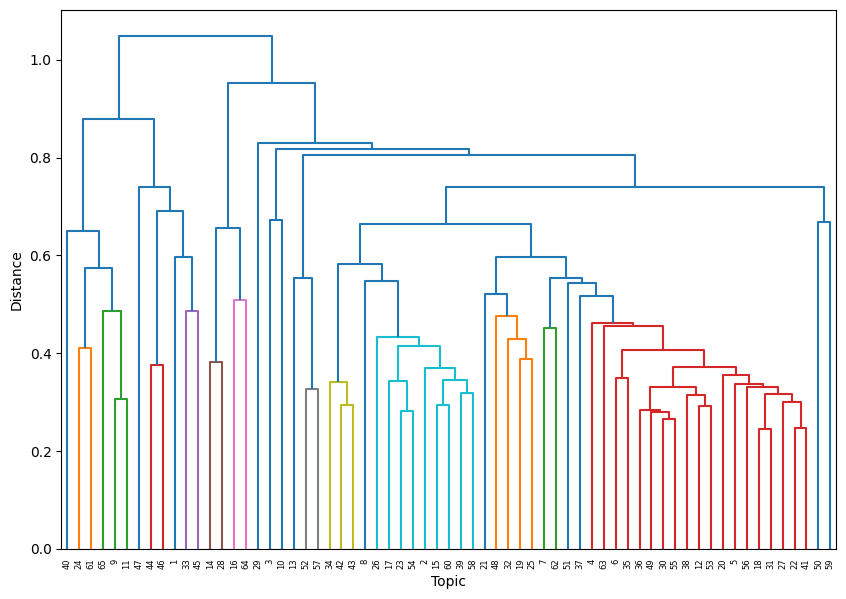

In [156]:
plot_dendogram(linkage_matrix, optimal_distance, labels=plot_labels, data_name='combined_comments_3')

In [ ]:
plot_tsne(clusters, reduced_emb, plot_labels, color=False, data_name='combined_comments_3')

In [160]:
clusters = fcluster(linkage_matrix, optimal_distance, criterion='distance')
np.save(f"./{data_name}/clusters.npy", clusters)

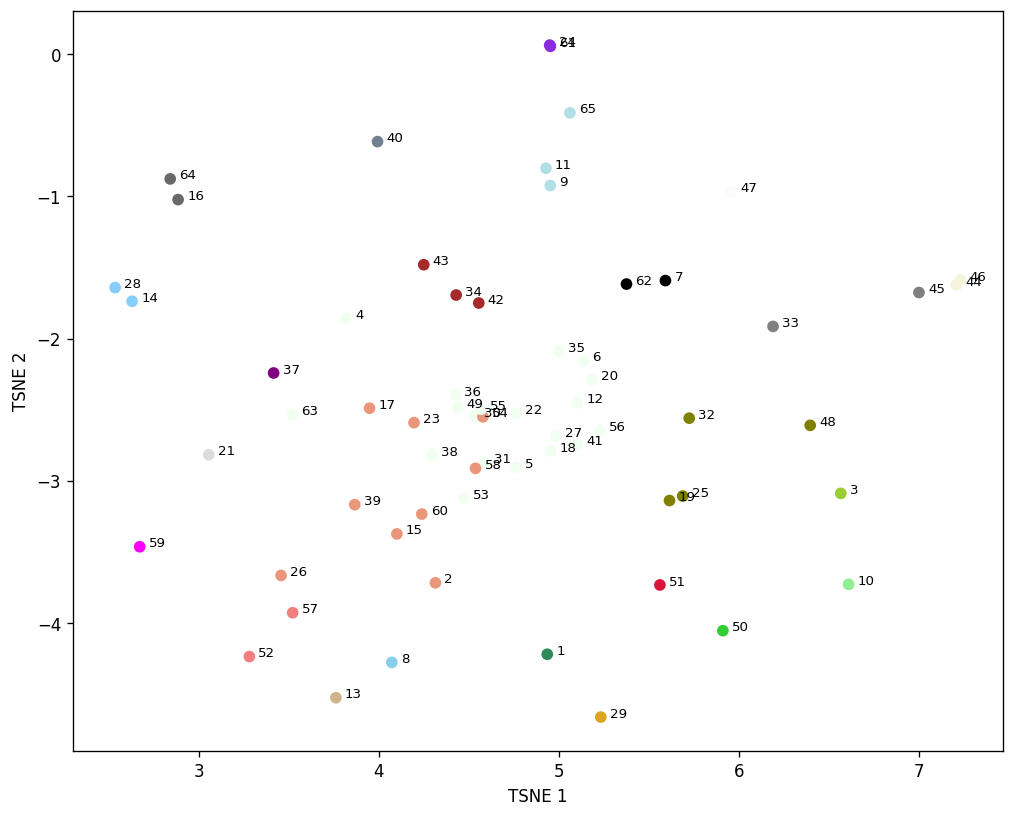

In [173]:
plot_tsne(clusters, reduced_emb, plot_labels, color=True, data_name=data_name, color_seed=10)

In [172]:
colors[37]

'indigo'

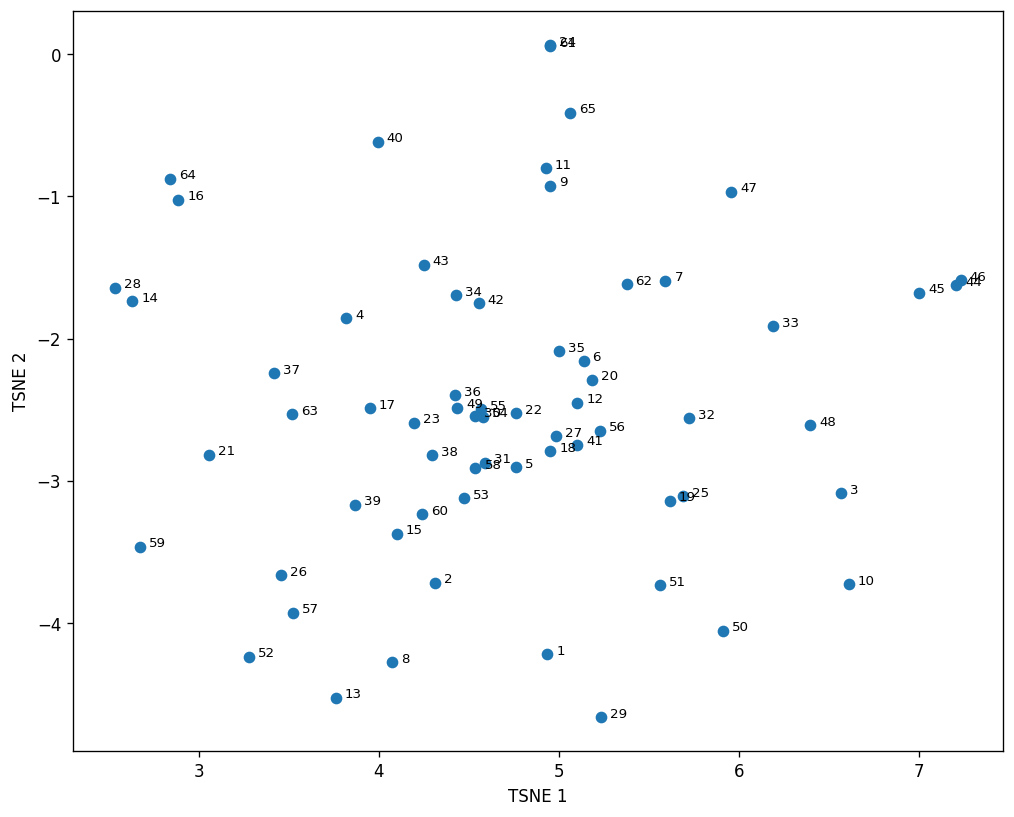

/tmp/ipykernel_32119/1426854321.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


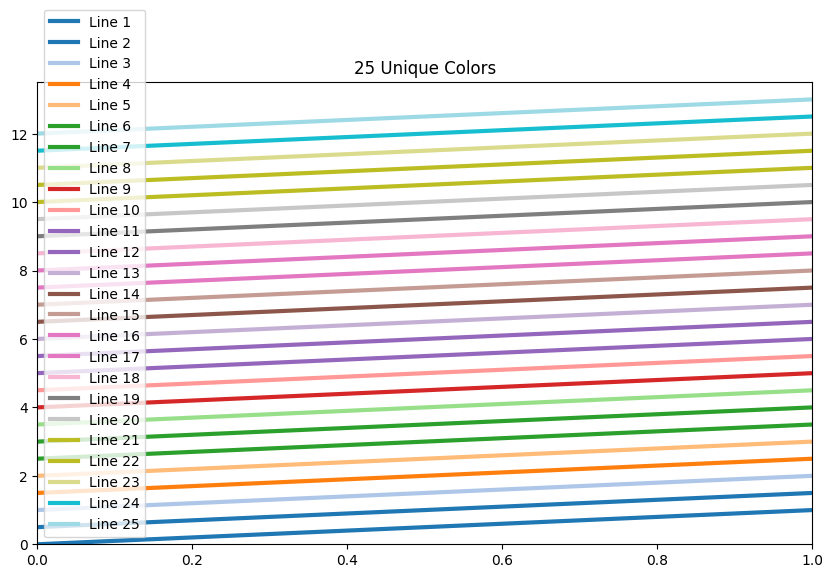

In [106]:
import matplotlib.pyplot as plt
import numpy as np

def generate_colors(n):
    cmap = plt.cm.get_cmap('tab20')
    return [cmap(i / n) for i in range(n)]

n = 25
colors = generate_colors(n)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot multiple lines with different colors and y-intercepts
for i, color in enumerate(colors):
    y_intercept = i * 0.5  # Adjust this value to spread out the lines
    ax.plot([0, 1], [y_intercept, y_intercept + 1], color=color, linewidth=3, label=f'Line {i+1}')

ax.set_xlim(0, 1)
ax.set_ylim(0, n * 0.5 + 1)
ax.legend()
plt.title(f'{n} Unique Colors')
plt.show()

In [149]:
color_list = get_color_list(max(clusters))
colors = [color_list[i-1] for i in clusters]
colors

['darkslategrey',
 'lightgoldenrodyellow',
 'blueviolet',
 'moccasin',
 'moccasin',
 'moccasin',
 'darkkhaki',
 'limegreen',
 'blanchedalmond',
 'beige',
 'blanchedalmond',
 'moccasin',
 'darkolivegreen',
 'darkgray',
 'lightgoldenrodyellow',
 'plum',
 'lightgoldenrodyellow',
 'moccasin',
 'springgreen',
 'moccasin',
 'lightskyblue',
 'moccasin',
 'lightgoldenrodyellow',
 'darkorange',
 'springgreen',
 'lightgoldenrodyellow',
 'moccasin',
 'darkgray',
 'yellowgreen',
 'moccasin',
 'moccasin',
 'springgreen',
 'khaki',
 'darkorchid',
 'moccasin',
 'moccasin',
 'mediumpurple',
 'moccasin',
 'lightgoldenrodyellow',
 'lightseagreen',
 'moccasin',
 'darkorchid',
 'darkorchid',
 'lightcoral',
 'khaki',
 'lightcoral',
 'darkmagenta',
 'springgreen',
 'moccasin',
 'lightsalmon',
 'midnightblue',
 'cadetblue',
 'moccasin',
 'lightgoldenrodyellow',
 'moccasin',
 'moccasin',
 'cadetblue',
 'lightgoldenrodyellow',
 'honeydew',
 'lightgoldenrodyellow',
 'darkorange',
 'darkkhaki',
 'moccasin',
 'pl

In [127]:
def get_color_list(n, seed=42):
    unwanted_colors = ['white', 'whitesmoke', 'floralwhite','ghostwhite', 'mintcream', 'azure', 'lavenderblush', 'seashell', 'linen', 'ivory','aliceblue']
    all_colors = list(mcolors.CSS4_COLORS.keys())
    all_colors = [i for i in all_colors if i not in unwanted_colors]

    random.seed(seed)
    selected_colors = random.sample(all_colors, n)
    return selected_colors

In [148]:
get_color_list(max(clusters), 42)

['darkorange',
 'blanchedalmond',
 'lightseagreen',
 'lightcoral',
 'khaki',
 'darkslategrey',
 'darkmagenta',
 'darkgray',
 'plum',
 'blueviolet',
 'beige',
 'cadetblue',
 'darkolivegreen',
 'darkorchid',
 'lightgoldenrodyellow',
 'limegreen',
 'springgreen',
 'lightskyblue',
 'darkkhaki',
 'moccasin',
 'mediumpurple',
 'midnightblue',
 'lightsalmon',
 'honeydew',
 'yellowgreen']

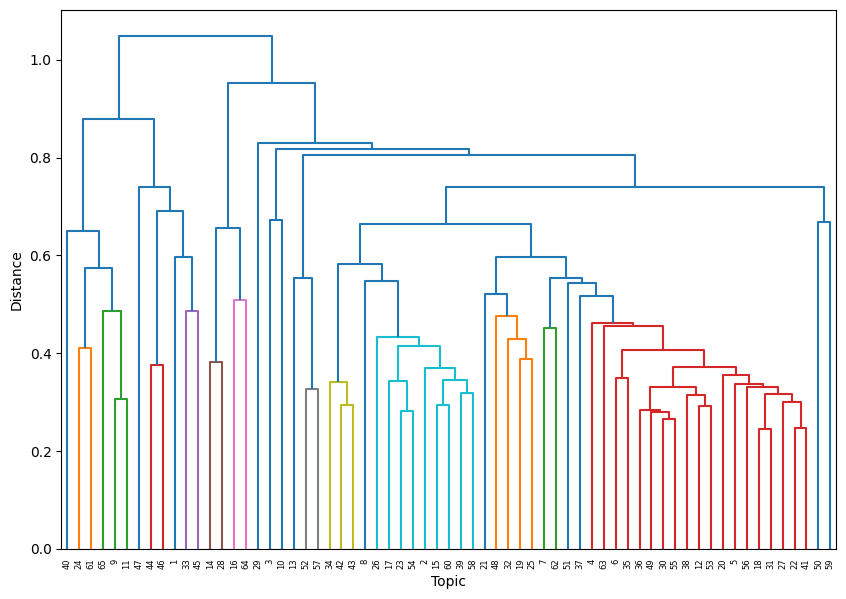

In [90]:
plot_dendogram(linkage_matrix, optimal_distance, labels=list(topic_emb_large_dict.keys()))

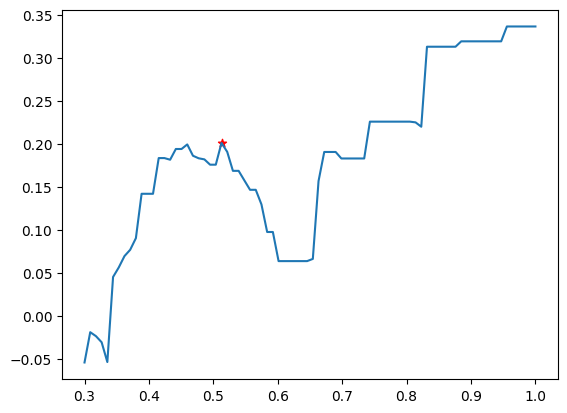

In [64]:
plt.plot(test_ds, scores)
plt.scatter(test_ds[max_index], scores[max_index], color='red', marker='*')

In [ ]:
def get_tsne(topic_emb_dict):
    tsne_model = TSNE(n_components=2, random_state=42)
    reduced_emb = tsne_model.fit_transform(np.array(list(topic_emb_dict.values())))
    return reduced_emb

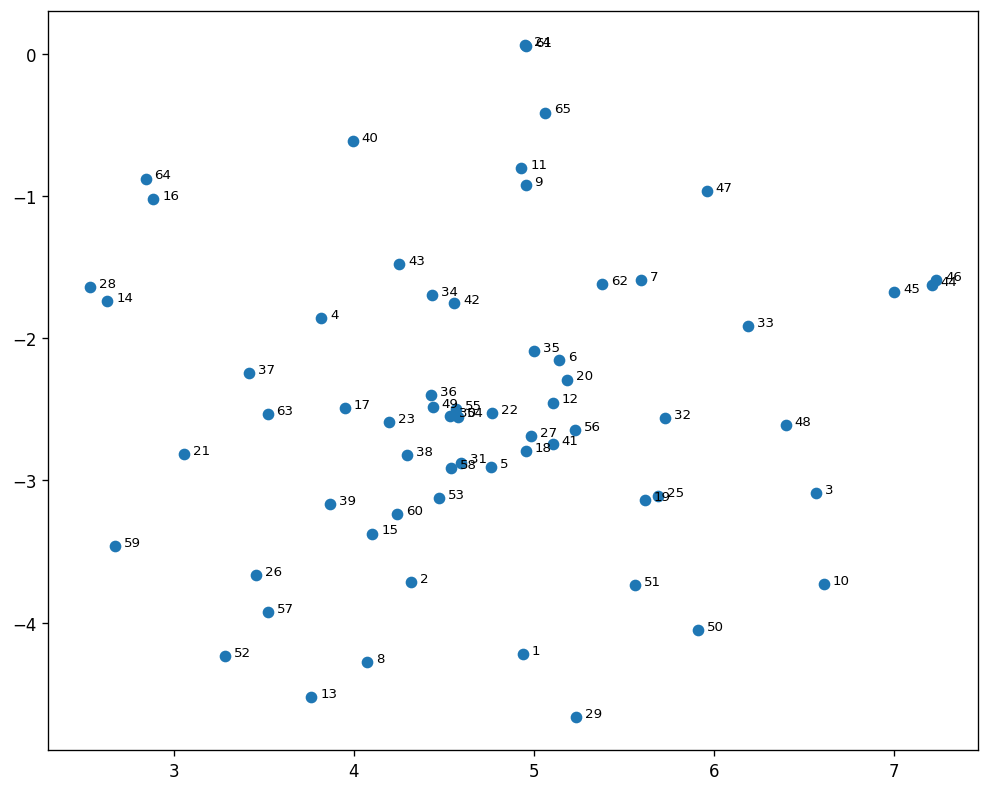

In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=120)

# tsne_model = TSNE(n_components=2, random_state=42)

# reduced_emb = tsne_model.fit_transform(np.array(list(topic_emb_large_dict.values())))
reduced_emb = get_tsne(topic_emb_large_dict)
x_axis = reduced_emb[:,0]
y_axis = reduced_emb[:,1]
labels = list(topic_emb_small_dict.keys())

plt.scatter(x_axis, y_axis)
for i in range(len(labels)):
    plt.text(x_axis[i]+0.05, y_axis[i], labels[i], fontsize=8)
plt.show()